In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np

from sklearn import metrics
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve

from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC,NuSVC

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_curve

from sklearn import metrics
from sklearn.metrics import accuracy_score,precision_recall_fscore_support,plot_roc_curve
from sklearn.model_selection import cross_val_score

# Importing DecisionTree and Ensemble technique Classifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor,GradientBoostingRegressor,RandomForestRegressor
from sklearn.metrics import classification_report 

import scikitplot as skplt

import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder,PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.naive_bayes import GaussianNB



C:\Users\lenovo\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


- Employee attrition class label is 1 and no attrition class label  is 0. 
- Class label 1 is of more interest to us.
- So the employee who is not attriting and is being predicted to be attriting then it's fine. 
- But employee who is about to attrite and is being predicted to be not attriting then we need to improve our model. i.e we need to reduce class 1 being predicted as class 0.


In [3]:
train_data=pd.read_csv('train.csv')

From Exploratory Data Analaysis we found that there are many corelated feature, so high correlation is one issue.
Feature Engineering is nesessary.


In [4]:
train_data.Behaviour.nunique()

1

In [5]:
train_data.drop(columns=['Id','Behaviour'],inplace=True)

 From data, it's  must to delete Behaviour column as it's constant value. Also Id column is unique  and doesn't helps in prediction. So needs to be deletes.
Columns to Delete:
- Behaviour
- Id

In [6]:
print(f"Number of duplicates in the training data are {train_data.duplicated().sum()} of {len(train_data)}, ie {(100* train_data.duplicated().sum()/len(train_data)).round(2)} % of data duplicated")


Number of duplicates in the training data are 628 of 1628, ie 38.57 % of data duplicated


As checked there are lot of duplicate records. We should remove duplicate records because there can be overfitting case

In [7]:
train_data.drop_duplicates(inplace=True)


In [8]:
train_data.shape

(1000, 27)

In [9]:
#Also we can check there is class imbalance after removing duplicates
train_data.Attrition.value_counts()

0    843
1    157
Name: Attrition, dtype: int64

In [10]:
#separate categorical and numerical columns
dtype_df=pd.DataFrame(train_data.dtypes).reset_index()
dtype_df=dtype_df.rename(columns={'index':'name',0:'type'})
cat_variables=dtype_df[dtype_df.type=='object']['name'].tolist()
num_var=dtype_df[dtype_df.type!='object']['name'].tolist()

In [11]:
print(cat_variables)
print(num_var)

['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
['Age', 'Attrition', 'DistanceFromHome', 'Education', 'EmployeeNumber', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobSatisfaction', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'CommunicationSkill']


In [12]:
#corelation check
num_var.remove('Attrition')
numerical_df=train_data[num_var]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(numerical_df.values, i) for i in range(numerical_df.shape[1])]
vif["features"] = numerical_df.columns
vif.sort_values(by=['VIF Factor'],ascending=False)

,VIF Factor,features
10,100.544367,PerformanceRating
9,42.125665,PercentSalaryHike
0,32.847989,Age
5,14.584347,JobInvolvement
12,13.615016,TotalWorkingYears
14,10.229251,YearsAtCompany
2,9.358355,Education
6,7.101860,JobSatisfaction
7,7.025604,MonthlyIncome
4,6.905842,EnvironmentSatisfaction


As checked there is high correlation  amongst feature variables. Let's reduce the  corelation by doing feature engineering.
Below feature engineering function has been generated after lots of iteration

In [13]:
def feature_engineering(data):
    data['JobInvolment_On_Salary']= data['JobInvolvement'] / data['MonthlyIncome'] * 1000
    data['DistanceFromHome_rootedTo_JobSatisfaction'] = data['DistanceFromHome']**(1/data['JobSatisfaction'])
    data['Mothers'] = np.where((data['Gender']=='Female') & (data['Age']>=36), 1,0)
    data['RateExtended'] = data['MonthlyIncome'] * (8 - data['JobSatisfaction'] - data['EnvironmentSatisfaction'])
    data['TotalJobSatisfaction'] = data['EnvironmentSatisfaction'] + data['JobSatisfaction']
    data['Sal_Rating']=data['PercentSalaryHike'] + data['PerformanceRating']
    data['Years_in_non_current_role']=data.YearsAtCompany-data.YearsInCurrentRole
    data.drop(['EnvironmentSatisfaction','YearsInCurrentRole','JobSatisfaction','PercentSalaryHike','MonthlyIncome','JobRole','PerformanceRating','Age'],axis=1,inplace=True)
    return data

In [14]:
new_data=feature_engineering(train_data)

In [15]:
new_data

,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,Gender,JobInvolvement,MaritalStatus,...,YearsSinceLastPromotion,YearsWithCurrManager,CommunicationSkill,JobInvolment_On_Salary,DistanceFromHome_rootedTo_JobSatisfaction,Mothers,RateExtended,TotalJobSatisfaction,Sal_Rating,Years_in_non_current_role
0,0,Non-Travel,Research & Development,2,3,Medical,571,Female,3,Single,...,6,7,4,1.170047,1.189207,0,2564,7,17,4
1,0,Travel_Rarely,Research & Development,12,4,Life Sciences,1614,Female,3,Married,...,1,1,2,0.643363,2.289428,1,9326,6,15,1
2,1,Travel_Rarely,Sales,2,1,Medical,842,Male,3,Single,...,7,3,5,0.581395,1.189207,0,5160,7,19,2
3,0,Travel_Rarely,Research & Development,24,1,Life Sciences,2014,Male,3,Single,...,1,7,4,0.730282,2.213364,0,12324,5,16,0
4,0,Travel_Rarely,Research & Development,3,3,Other,689,Male,3,Married,...,7,8,1,0.317999,1.442250,0,18868,6,18,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,Non-Travel,Sales,10,4,Medical,592,Male,3,Single,...,9,7,4,0.300601,1.778279,0,19960,6,17,7
996,0,Travel_Rarely,Research & Development,16,3,Life Sciences,1641,Female,3,Single,...,3,3,2,0.377596,2.000000,1,7945,7,18,2
997,1,Travel_Rarely,Sales,9,2,Medical,118,Male,2,Single,...,4,7,4,0.207922,1.732051,0,9619,7,19,1
998,0,Travel_Rarely,Research & Development,2,3,Medical,833,Female,2,Single,...,0,0,5,0.290824,1.189207,0,6877,7,28,0


In [16]:
dtype_df=pd.DataFrame(new_data.dtypes).reset_index()
dtype_df=dtype_df.rename(columns={'index':'name',0:'type'})
cat_variables=dtype_df[dtype_df.type=='object']['name'].tolist()
num_var=dtype_df[dtype_df.type!='object']['name'].tolist()


In [17]:
num_var

['Attrition',
 'DistanceFromHome',
 'Education',
 'EmployeeNumber',
 'JobInvolvement',
 'NumCompaniesWorked',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'YearsAtCompany',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager',
 'CommunicationSkill',
 'JobInvolment_On_Salary',
 'DistanceFromHome_rootedTo_JobSatisfaction',
 'Mothers',
 'RateExtended',
 'TotalJobSatisfaction',
 'Sal_Rating',
 'Years_in_non_current_role']

In [18]:
#corelation check
numerical_df=new_data[num_var]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(numerical_df.values, i) for i in range(numerical_df.shape[1])]
vif["features"] = numerical_df.columns
vif.sort_values(by=['VIF Factor'],ascending=False)

,VIF Factor,features
4,22.132607,JobInvolvement
17,18.729697,TotalJobSatisfaction
9,18.153850,YearsAtCompany
18,17.932026,Sal_Rating
7,9.048925,TotalWorkingYears
2,8.848843,Education
13,7.068094,JobInvolment_On_Salary
11,6.448851,YearsWithCurrManager
12,5.529290,CommunicationSkill
8,5.489200,TrainingTimesLastYear


As we can see by doing feature engineering and removing some variables, correlation amongst variables has been reduced significantly

In [19]:
#Scale the values
rb=MinMaxScaler()
new_data[num_var]=rb.fit_transform(new_data[num_var])

In [20]:
new_data

,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,Gender,JobInvolvement,MaritalStatus,...,YearsSinceLastPromotion,YearsWithCurrManager,CommunicationSkill,JobInvolment_On_Salary,DistanceFromHome_rootedTo_JobSatisfaction,Mothers,RateExtended,TotalJobSatisfaction,Sal_Rating,Years_in_non_current_role
0,0.0,Non-Travel,Research & Development,0.035714,0.50,Medical,0.275762,Female,0.666667,Single,...,0.400000,0.411765,0.75,0.383138,0.006757,0.0,0.023841,0.833333,0.200000,0.133333
1,0.0,Travel_Rarely,Research & Development,0.392857,0.75,Life Sciences,0.780358,Female,0.666667,Married,...,0.066667,0.058824,0.25,0.202963,0.046051,1.0,0.086718,0.666667,0.066667,0.033333
2,1.0,Travel_Rarely,Sales,0.035714,0.00,Medical,0.406870,Male,0.666667,Single,...,0.466667,0.176471,1.00,0.181764,0.006757,0.0,0.047980,0.833333,0.333333,0.066667
3,0.0,Travel_Rarely,Research & Development,0.821429,0.00,Life Sciences,0.973875,Male,0.666667,Single,...,0.066667,0.411765,0.75,0.232697,0.043334,0.0,0.114595,0.500000,0.133333,0.000000
4,0.0,Travel_Rarely,Research & Development,0.071429,0.50,Other,0.332850,Male,0.666667,Married,...,0.466667,0.470588,0.00,0.091658,0.015795,0.0,0.175444,0.666667,0.266667,0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,Non-Travel,Sales,0.321429,0.75,Medical,0.285922,Male,0.666667,Single,...,0.600000,0.411765,0.75,0.085706,0.027796,0.0,0.185598,0.666667,0.200000,0.233333
996,0.0,Travel_Rarely,Research & Development,0.535714,0.50,Life Sciences,0.793420,Female,0.666667,Single,...,0.200000,0.176471,0.25,0.112045,0.035714,1.0,0.073877,0.833333,0.266667,0.066667
997,1.0,Travel_Rarely,Sales,0.285714,0.25,Medical,0.056604,Male,0.333333,Single,...,0.266667,0.411765,0.75,0.054001,0.026145,0.0,0.089442,0.833333,0.333333,0.033333
998,0.0,Travel_Rarely,Research & Development,0.035714,0.50,Medical,0.402516,Female,0.333333,Single,...,0.000000,0.000000,1.00,0.082361,0.006757,0.0,0.063946,0.833333,0.933333,0.000000


In [21]:
final_df=new_data.copy(deep=True)
#encode categorical variables
final_df=pd.get_dummies(final_df,cat_variables,drop_first=True)
final_df.shape

(1000, 33)

In [22]:
#split train test data
y=final_df['Attrition']
X=final_df.drop(columns=['Attrition'],axis=1)
X_train, X_test, y_train, y_test=train_test_split(X,y,random_state=42,test_size=0.2,shuffle=True)

In [23]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(800, 32) (800,)
(200, 32) (200,)


## LogisticRegression

In [106]:
lr=LogisticRegression()
param_grid = {
              "C": [0.001,0.01,0.1,0.5,0.15,1,10,5,100],
              "solver": ['newton-cg','lbfgs','liblinear','sag','saga'],
              }

CV_lr = GridSearchCV(estimator=lr, param_grid=param_grid, cv= 5)
CV_lr.fit(X_train, y_train)



C:\Users\lenovo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\lenovo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\lenovo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\lenovo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\lenovo\AppData\Local\Continuum\anaconda

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 0.15, 1, 10, 5, 100],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']})

In [111]:
print("Best Parameters:")
print(CV_lr.best_params_)
print(CV_lr.best_score_)

Best Parameters:
{'C': 10, 'solver': 'liblinear'}
0.8787499999999999


In [112]:
lr_predictions=CV_lr.predict(X_test)

In [113]:
print(confusion_matrix(y_test,lr_predictions))


print(classification_report(y_test,lr_predictions))

[[161   6]
 [ 17  16]]
              precision    recall  f1-score   support

         0.0       0.90      0.96      0.93       167
         1.0       0.73      0.48      0.58        33

    accuracy                           0.89       200
   macro avg       0.82      0.72      0.76       200
weighted avg       0.88      0.89      0.88       200



In [114]:
metrics_value=precision_recall_fscore_support(y_test, lr_predictions, average=None,labels=[0,1])
recall_for_class_1_logistic_regression=metrics_value[1][1]


0.89


C:\Users\lenovo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


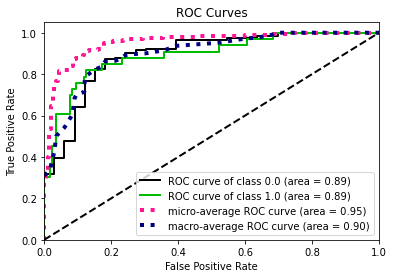

In [122]:
auc_lr=round(roc_auc_score(y_test,CV_lr.predict_log_proba(X_test)[:,1]),2)
print(auc_lr)
skplt.metrics.plot_roc_curve(y_test, CV_lr.predict_proba(X_test))

## SVC

In [123]:
svc_model=SVC(probability=True)


param_grid = {
            "kernel":['linear','poly','rbf','sigmoid'],
             'gamma' :[0.001, 0.01, 0.1, 1],
              "C": [0.001,0.01,0.1,0.5,0.15,1,10]
              }

CV_svc = GridSearchCV(estimator=svc_model, param_grid=param_grid, cv= 6)
CV_svc.fit(X_train, y_train)


GridSearchCV(cv=6, estimator=SVC(probability=True),
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 0.15, 1, 10],
                         'gamma': [0.001, 0.01, 0.1, 1],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [124]:
print(CV_svc.best_params_)
print(CV_svc.best_score_)

{'C': 10, 'gamma': 0.001, 'kernel': 'linear'}
0.876182994800434


In [125]:
predictions_svc=CV_svc.predict(X_test)

In [126]:
print(confusion_matrix(y_test,predictions_svc))


print(classification_report(y_test,predictions_svc))

[[162   5]
 [ 16  17]]
              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94       167
         1.0       0.77      0.52      0.62        33

    accuracy                           0.90       200
   macro avg       0.84      0.74      0.78       200
weighted avg       0.89      0.90      0.89       200



In [127]:
metrics_value=precision_recall_fscore_support(y_test, predictions_svc, average=None,labels=[0,1])
recall_for_class_1_SVC=round(metrics_value[1][1],2)
auc_svc=round(roc_auc_score(y_test,CV_svc.predict_log_proba(X_test)[:,1]),2)
auc_svc

0.91

C:\Users\lenovo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


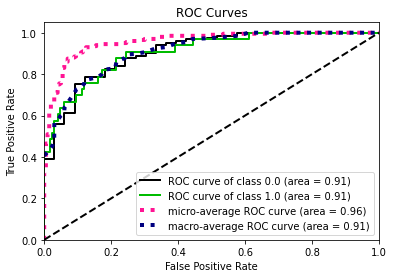

In [128]:
skplt.metrics.plot_roc_curve(y_test, CV_svc.predict_proba(X_test))

## Naive Bayes

In [133]:
gb=GaussianNB()
gb.fit(X_train,y_train)
predictions_gb=gb.predict(X_test)
print(confusion_matrix(y_test,predictions_gb))


print(classification_report(y_test,predictions_gb))

[[132  35]
 [  9  24]]
              precision    recall  f1-score   support

         0.0       0.94      0.79      0.86       167
         1.0       0.41      0.73      0.52        33

    accuracy                           0.78       200
   macro avg       0.67      0.76      0.69       200
weighted avg       0.85      0.78      0.80       200



In [136]:
metrics_value=precision_recall_fscore_support(y_test, predictions_gb, average=None,labels=[0,1])
recall_for_class_1_NaiveBayes=round(metrics_value[1][1],2)
print(recall_for_class_1_NaiveBayes)


0.73


AUC score 0.83


C:\Users\lenovo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


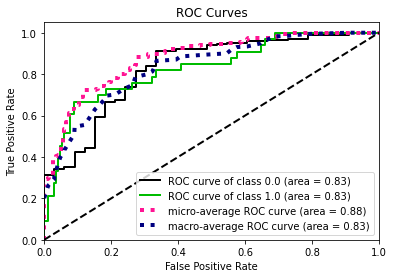

In [138]:
auc_naivebayes=round(roc_auc_score(y_test,gb.predict_log_proba(X_test)[:,1]),2)
print('AUC score {}'.format(auc_naivebayes))
skplt.metrics.plot_roc_curve(y_test, gb.predict_proba(X_test))

## Decision Tree

In [143]:
dtree=DecisionTreeClassifier(random_state=42)
param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_split": [10, 20, 40],
              "max_depth": range(1,20),
              "min_samples_leaf": range(2,40),
              "max_leaf_nodes": range(2,20),
              }

CV_dtree = RandomizedSearchCV(estimator=dtree, param_distributions=param_grid, cv= 6)
CV_dtree.fit(X_train, y_train)

print("Best Parameters:")
print(CV_dtree.best_params_)
print(CV_dtree.best_score_)


Best Parameters:
{'min_samples_split': 20, 'min_samples_leaf': 24, 'max_leaf_nodes': 7, 'max_depth': 3, 'criterion': 'gini'}
0.8449668948490628


In [147]:
final_dtree_model=DecisionTreeClassifier(min_samples_split= 20, min_samples_leaf=24, max_leaf_nodes= 7, max_depth=3,criterion='entropy')
final_dtree_model.fit(X_train,y_train)
pred_dtree=final_dtree_model.predict(X_test)

In [148]:
print(confusion_matrix(y_test,pred_dtree))

print(classification_report(y_test,pred_dtree))

[[164   3]
 [ 30   3]]
              precision    recall  f1-score   support

         0.0       0.85      0.98      0.91       167
         1.0       0.50      0.09      0.15        33

    accuracy                           0.83       200
   macro avg       0.67      0.54      0.53       200
weighted avg       0.79      0.83      0.78       200



In [149]:
metrics_value=precision_recall_fscore_support(y_test, pred_dtree, average=None,labels=[0,1])
recall_for_class_1_DecisionTree=round(metrics_value[1][1],2)


AUC score 0.77


C:\Users\lenovo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


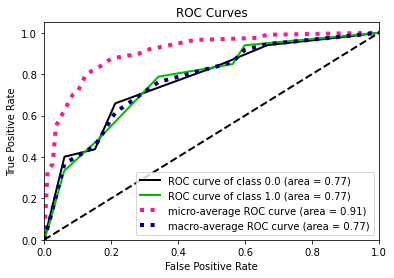

In [150]:
auc_dtree=round(roc_auc_score(y_test,final_dtree_model.predict_log_proba(X_test)[:,1]),2)
print('AUC score {}'.format(auc_dtree))
skplt.metrics.plot_roc_curve(y_test, final_dtree_model.predict_proba(X_test))

## RandomForest Classifier

In [151]:
RF_model=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [20,30,40,50,100,125,150,175,200,225,250,275],
    'max_depth' : range(2,20),
    'criterion':["gini","entropy"],
    "min_samples_leaf": range(1,20),
    "max_leaf_nodes": range(2,20),
    'max_features':["auto", "sqrt", "log2"]
}

CV_rfc = RandomizedSearchCV(estimator=RF_model, param_distributions=param_grid, cv= 6,)
CV_rfc.fit(X_train, y_train)

print("Best Parameters:")
print(CV_rfc.best_params_)
print(CV_rfc.best_score_)


Best Parameters:
{'n_estimators': 200, 'min_samples_leaf': 5, 'max_leaf_nodes': 15, 'max_features': 'auto', 'max_depth': 10, 'criterion': 'gini'}
0.8512419107470167


In [152]:
rc_predictions=CV_rfc.predict(X_test)

In [154]:
print(confusion_matrix(y_test,rc_predictions))

print(classification_report(y_test,rc_predictions))

[[167   0]
 [ 33   0]]
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91       167
         1.0       0.00      0.00      0.00        33

    accuracy                           0.83       200
   macro avg       0.42      0.50      0.46       200
weighted avg       0.70      0.83      0.76       200



AUC score 0.85


C:\Users\lenovo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


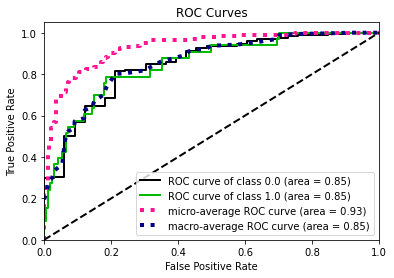

In [155]:
metrics_value=precision_recall_fscore_support(y_test, rc_predictions, average=None,labels=[0,1])
recall_for_class_1_RandomForest=round(metrics_value[1][1],2)


auc_randomforest=round(roc_auc_score(y_test,CV_rfc.predict_log_proba(X_test)[:,1]),2)
print('AUC score {}'.format(auc_randomforest))
skplt.metrics.plot_roc_curve(y_test, CV_rfc.predict_proba(X_test))

## GradientBoosting

In [161]:
from sklearn.ensemble import GradientBoostingClassifier


gradient_boosting=GradientBoostingClassifier(random_state=42)

param_grid = { 
    'learning_rate':[0.15,0.1,0.05,0.01,0.001],
    'n_estimators':[20,30,40,50,75,100,125,150,175,157,200,225,250,275,300,325,350],
    'max_depth' : range(2,20),
    "max_leaf_nodes": range(2,20),
    'min_samples_split':range(2,15),
    'criterion':['friedman_mse','mse', 'mae']
    
}

CV_gdb = RandomizedSearchCV(estimator=gradient_boosting,param_distributions=param_grid, cv= 6)
CV_gdb.fit(X_train, y_train)

print("Best Parameters:")
print(CV_gdb.best_params_)
print(CV_gdb.best_score_)


Best Parameters:
{'n_estimators': 175, 'min_samples_split': 13, 'max_leaf_nodes': 17, 'max_depth': 12, 'learning_rate': 0.05, 'criterion': 'mse'}
0.8574701679572065


In [163]:
gdb_prediction=CV_gdb.predict(X_test)

print(confusion_matrix(y_test,gdb_prediction))

print(classification_report(y_test,gdb_prediction))

[[160   7]
 [ 24   9]]
              precision    recall  f1-score   support

         0.0       0.87      0.96      0.91       167
         1.0       0.56      0.27      0.37        33

    accuracy                           0.84       200
   macro avg       0.72      0.62      0.64       200
weighted avg       0.82      0.84      0.82       200



AUC score 0.76


C:\Users\lenovo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


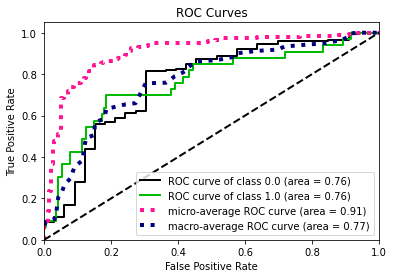

In [166]:
metrics_value=precision_recall_fscore_support(y_test, gdb_prediction, average=None,labels=[0,1])
recall_for_class_1_GradientBoosting=round(metrics_value[1][1],2)


auc_gradientboosting=round(roc_auc_score(y_test,CV_gdb.predict_log_proba(X_test)[:,1]),2)
print('AUC score {}'.format(auc_gradientboosting))
skplt.metrics.plot_roc_curve(y_test, CV_gdb.predict_proba(X_test))


## Bagging Classifier

In [244]:
from sklearn.ensemble import BaggingClassifier
bgc=BaggingClassifier(base_estimator=gb)
param_grid={
    'n_estimators': range(10,100)
}

CV_bgc = RandomizedSearchCV(estimator=bgc,param_distributions=param_grid, cv= 6)
CV_bgc.fit(X_train, y_train)

print("Best Parameters:")
print(CV_bgc.best_params_)
print(CV_bgc.best_score_)


#bgr.fit(X_train,y_train)
bgr_pred=CV_bgc.predict(X_test)
print(confusion_matrix(y_test,bgr_pred))

print(classification_report(y_test,bgr_pred))

Best Parameters:
{'n_estimators': 17}
0.7686193094676991
[[138  29]
 [  9  24]]
              precision    recall  f1-score   support

         0.0       0.94      0.83      0.88       167
         1.0       0.45      0.73      0.56        33

    accuracy                           0.81       200
   macro avg       0.70      0.78      0.72       200
weighted avg       0.86      0.81      0.83       200



AUC score 0.85


C:\Users\lenovo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


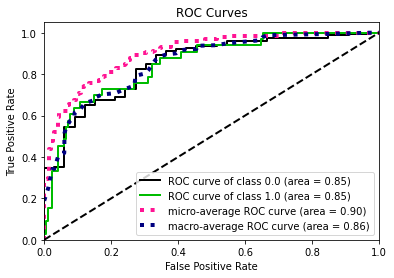

In [253]:
metrics_value=precision_recall_fscore_support(y_test, bgr_pred, average=None,labels=[0,1])
recall_for_class_1_bagging_classifier=round(metrics_value[1][1],2)


auc_bagging_classifier=round(roc_auc_score(y_test,CV_bgc.predict_log_proba(X_test)[:,1]),2)
print('AUC score {}'.format(auc_bagging_classifier))
skplt.metrics.plot_roc_curve(y_test, CV_bgc.predict_proba(X_test))


In [297]:
from sklearn.ensemble import AdaBoostClassifier

In [322]:
ada=AdaBoostClassifier(base_estimator=gb)

param_grid={
    'n_estimators':range(10,100),
    'learning_rate':[0.1,0.01,1,10]
}


CV_ada = RandomizedSearchCV(estimator=ada,param_distributions=param_grid, cv= 6)
CV_ada.fit(X_train, y_train)

print("Best Parameters:")
print(CV_ada.best_params_)
print(CV_ada.best_score_)


#bgr.fit(X_train,y_train)
ada_pred=CV_ada.predict(X_test)
print(confusion_matrix(y_test,ada_pred))

print(classification_report(y_test,ada_pred))

C:\Users\lenovo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\lenovo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\lenovo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py", line 443, in fit
    return super().fit(X, y, sample_weight)
  File "C:\Users\lenovo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py", line 134, in fit
    random_state)
  File "C:\Users\lenovo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py", line 503, in _boost
    return self._boost_real(iboost, X, y, sample_weight, random_sta

C:\Users\lenovo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\lenovo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\lenovo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py", line 443, in fit
    return super().fit(X, y, sample_weight)
  File "C:\Users\lenovo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py", line 134, in fit
    random_state)
  File "C:\Users\lenovo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py", line 503, in _boost
    return self._boost_real(iboost, X, y, sample_weight, random_sta

Best Parameters:
{'n_estimators': 73, 'learning_rate': 0.01}
0.8637358321176075
[[163   4]
 [ 17  16]]
              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94       167
         1.0       0.80      0.48      0.60        33

    accuracy                           0.90       200
   macro avg       0.85      0.73      0.77       200
weighted avg       0.89      0.90      0.88       200



AUC score 0.88


C:\Users\lenovo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


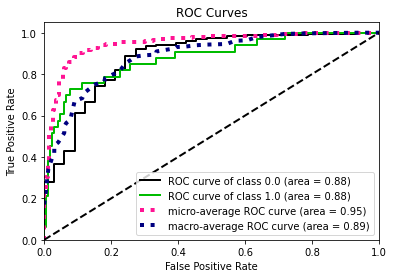

In [323]:
metrics_value=precision_recall_fscore_support(y_test, ada_pred, average=None,labels=[0,1])
recall_for_class_1_adaclassifier=round(metrics_value[1][1],2)


auc_adaclassifier=round(roc_auc_score(y_test,CV_ada.predict_log_proba(X_test)[:,1]),2)
print('AUC score {}'.format(auc_adaclassifier))
skplt.metrics.plot_roc_curve(y_test, CV_ada.predict_proba(X_test))


## Visualize various model performance

In [324]:
auc_list=[auc_lr,auc_svc,auc_naivebayes,auc_dtree,auc_randomforest,auc_gradientboosting,auc_bagging_classifier,auc_adaclassifier]
recall_for_1_list=[recall_for_class_1_logistic_regression,recall_for_class_1_SVC,recall_for_class_1_NaiveBayes,recall_for_class_1_DecisionTree,recall_for_class_1_RandomForest,recall_for_class_1_GradientBoosting,recall_for_class_1_bagging_classifier,recall_for_class_1_adaclassifier]
model_name_list=['Logistic Regression','SVC','Gaussian Navie Bayes','Decision Tree','RandomForest','Gradient Boosting','Bagging Classifier','Ada Boosting']

In [325]:
results_df=pd.DataFrame(
{
    'model_name':model_name_list,
    'auc_score':auc_list,
    'recall_score':recall_for_1_list
    
}
)

In [326]:
results_df

,model_name,auc_score,recall_score
0,Logistic Regression,0.89,0.484848
1,SVC,0.91,0.520000
2,Gaussian Navie Bayes,0.83,0.730000
3,Decision Tree,0.77,0.090000
4,RandomForest,0.85,0.000000
5,Gradient Boosting,0.76,0.270000
6,Bagging Classifier,0.85,0.730000
7,Ada Boosting,0.88,0.480000


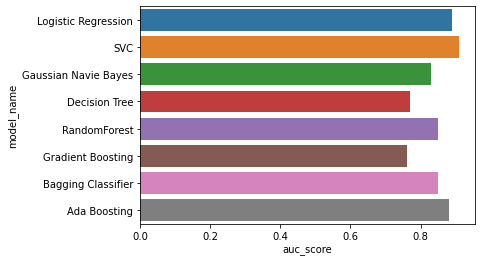

In [327]:
sns.barplot(data=results_df,x='auc_score',y='model_name')

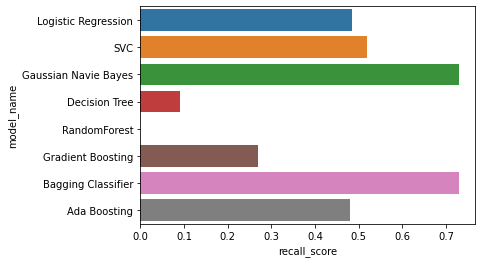

In [328]:
sns.barplot(data=results_df,x='recall_score',y='model_name')

AUC–ROC curve is the model selection metric for bi–multi class classification problem. ROC is a probability curve for different classes. ROC tells us how good the model is for distinguishing the given classes, in terms of the predicted probability.

A typical ROC curve has False Positive Rate (FPR) on the X-axis and True Positive Rate (TPR) on the Y-axis.

The bigger the area covered, the better the machine learning models is at distinguishing the given classes. Ideal value for AUC is 1.

When to Use ROC vs. Precision-Recall Curves?
Generally, the use of ROC curves and precision-recall curves are as follows:

- ROC curves should be used when there are roughly equal numbers of observations for each class.
- Precision-Recall curves should be used when there is a moderate to large class imbalance.





Navie Bayes best helps in identifying True positive.

We have created BaggingClassifier  using Naive Bayes as the base classifier, it helps in best reduction of False values for both the classes.

BaggingClassifier, has best balance between Recall score and AUC value for class 1

## Save model

In [294]:
import pickle

In [295]:
filename = 'finalized_model.pkl'
pickle.dump(CV_bgc, open(filename, 'wb'))
